# Learning the Advection-Diffusion Equation

$$ u_t = (xu)_x + 0.1u_{xx}$$

In [1]:
import sys; sys.path.append('../')
import scipy.io as sio
import numpy as np
import time as _time
import matplotlib.pylab as plt
from typing import List
from mpl_toolkits.mplot3d import Axes3D

import scikit_tt as scikit 
import scikit_tt.data_driven.transform as tdt
import scikit_tt.data_driven as reg
from scikit_tt.data_driven.transform import Function # GitHub: https://github.com/PGelss/ scikit_tt.

import auxiliary as aux

In [2]:
# Load data
data = sio.loadmat('Advection_Diffusion.mat')
h = data['h'][0][0]
k = data['k']
u = data['u']
alpha = data['alpha'][0][0]
u0 = data['u0']
# Define mesh
tmesh = data['tmesh']
xmesh = data['xmesh']

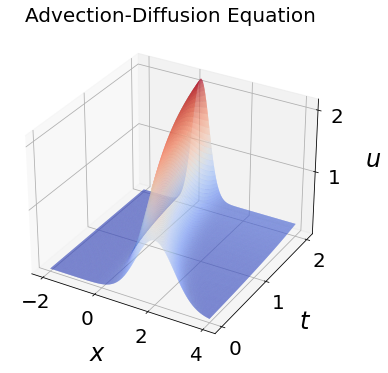

In [3]:
fig = plt.figure(figsize=(6.5,6))
ax = plt.axes(projection='3d')
surf = ax.plot_surface(xmesh, tmesh, u, cmap=plt.cm.coolwarm,
                       rstride=1, cstride=1, linewidth=0)
ax.xaxis.set_major_locator(plt.MultipleLocator(2))
ax.yaxis.set_major_locator(plt.MultipleLocator(1))
ax.zaxis.set_major_locator(plt.MultipleLocator(1))
ax.set_xlabel('$x$', fontsize = 24, labelpad = 15.0)
ax.set_ylabel('$t$', fontsize = 24, labelpad = 15.0)
ax.set_zlabel('$u$', fontsize = 24, labelpad = 15.0)
plt.xticks(fontsize = 20)
plt.yticks(fontsize = 20)
ax.tick_params(axis='z', labelsize=20)
plt.title('Advection-Diffusion Equation', fontsize = 20)
plt.show()

# Compute partial derivtives of $u$

In [4]:
ux = aux.dudx(u, h)
uxx = aux.dudx(ux, h)
ut = aux.dudt(u, k)

# Collect candidate functions for the dictionary matrix

In [5]:
T1 = 40 # subset time
T2 = 135
T = T1-T2
M1 = 50 # subset space
M2 = 110
M = M2-M1
U = np.array([u[T1:T2,M1:M2].reshape(T*(M)),
              ux[T1:T2,M1:M2].reshape(T*(M)),
              uxx[T1:T2,M1:M2].reshape(T*(M)),
              xmesh[T1:T2,M1:M2].reshape(T*(M)),])
v = np.array([ut[T1:T2,M1:M2].reshape(T*(M))])


# Construct the exact solution $\Xi^*$

Construction of the exact coefficient tensor for the application of our method to the Burgers' equation using the basic set $\mathcal{P}$ and $\mathcal{U}$.

In [6]:
P = [lambda t: 1, lambda t: t]
p = len(P)

core_type_1 = np.zeros([1, p, 1, 1])
core_type_1[0, 0, 0, 0] = 1

core_type_2 = np.zeros([1, p, 1, 1])
core_type_2[0, 1, 0, 0] = 1

core_type_4 = np.zeros([1, 1, 1, 1])
core_type_4[0, 0, 0, 0] = 1

cores = [core_type_1]
cores.append(core_type_2)
cores.append(core_type_1)
cores.append(core_type_2)
cores.append(core_type_4)

coefficient_tensor = scikit.TT(cores) # ux x

cores = [core_type_2]
cores.append(core_type_1)
cores.append(core_type_1)
cores.append(core_type_1)
cores.append(core_type_4)

coefficient_tensor += scikit.TT(cores) # u

cores = [core_type_1]
cores.append(core_type_1)
cores.append(core_type_2*0.1)
cores.append(core_type_1)
cores.append(core_type_4)

coefficient_tensor += scikit.TT(cores) # 0.1u_xx

xi_exact = coefficient_tensor

# Solve for $\Xi$

In [7]:
start_time = scikit.utils.progress('Running MANDy (eps=1e-10)', 0)
with scikit.utils.timer() as time:
    xi = aux.mandy_cm(U, v, P, threshold=1e-10)

Running MANDy (eps=1e-10)                      
                                         0.0000%
CPU time: 0.0000s 

In [8]:
xi.full().flatten()

array([-7.24000335e-05, -4.04385702e-05,  9.81243847e-02,  1.60498123e-02,
        7.80779157e-03,  9.90190645e-01, -3.49200872e-04,  2.80869487e-04,
        9.90095482e-01,  6.07339123e-03,  1.58144934e-03, -1.63148261e-03,
       -4.53464711e-03,  5.37157986e-03, -1.45989775e-04,  1.83134095e-04])

In [9]:
rel_errors= (xi - xi_exact).norm() / xi_exact.norm()
scikit.utils.progress('Running MANDy (eps=1e-10)', 100, cpu_time=_time.time() - start_time)
print("Relative error to identify Burger's equation:", rel_errors)

Running MANDy (eps=1e-10)                      
                                           100%
CPU time: 3.7221s 

Relative error to identify Burger's equation: 0.017393988670277586


In [10]:
# Candidates
candidates = []
for u in ['', 'u ']:
    for ux in ['', 'ux ']:
        for uxx in ['', 'uxx ']:
            for xmesh in ['', 'x']:
                candidates.append(u+ux+uxx+xmesh)
candidates[0]='1'
candidates

['1',
 'x',
 'uxx ',
 'uxx x',
 'ux ',
 'ux x',
 'ux uxx ',
 'ux uxx x',
 'u ',
 'u x',
 'u uxx ',
 'u uxx x',
 'u ux ',
 'u ux x',
 'u ux uxx ',
 'u ux uxx x']